In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

In [13]:
# Define Instantaneous forward rate
def inst_fwd_rate(t,P0T):
    dt = 0.01    
    expr = - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    return expr

In [14]:
# Calculate the first short rate
def init_short_rate(P0T):
    isr = inst_fwd_rate(0.001,P0T)
    return isr

## Hull White 1-Factor Model Setup

In [15]:
########################### SIMULATE HW 1F PATHS ############################
def HW1_Paths(Num_Paths,Num_Steps,T,P0T, lambd, sigma):    
    isr = inst_fwd_rate(0.001,P0T)
    theta = lambda t: 1.0/lambd * (inst_fwd_rate(t+dt,P0T)-inst_fwd_rate(t-dt,P0T))/(2.0*dt) + inst_fwd_rate(t,P0T)\
          + sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    Z = np.random.normal(0.0,1.0,[Num_Paths,Num_Steps])
    W = np.zeros([Num_Paths, Num_Steps+1])
    R = np.zeros([Num_Paths, Num_Steps+1])
    R[:,0]=isr
    time = np.zeros([Num_Steps+1])
        
    dt = T / float(Num_Steps)
    for i in range(0,Num_Steps):
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + sigma* (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt

    paths = {"time":time,"R":R}
    return paths

##################################   Calculate the parameters of the HW1 Affine Formula      ##################
def HW1_theta(lambd,sigma,P0T):
    dt = 0.01    
    theta = lambda t: 1.0/lambd * (inst_fwd_rate(t+dt,P0T)-inst_fwd_rate(t-dt,P0T))/(2.0*dt) + \
        inst_fwd_rate(t,P0T) + sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    return theta

def HW1_A(lambd,sigma,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW1_theta(lambd,sigma,P0T)    
    part1 = lambd * np.trapezoid(theta(T2-zGrid)*B_r(zGrid),zGrid)
    part2 = sigma*sigma/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + sigma*sigma*tau/(2.0*lambd*lambd)
    return part1 + part2

def HW1_B(lambd,sigma,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW1_ZCB(lambd,sigma,P0T,T1,T2,rT1):
    A_r = HW1_A(lambd,sigma,P0T,T1,T2)
    B_r = HW1_B(lambd,sigma,T1,T2)
    return np.exp(A_r + B_r *rT1)

## Hull White 2-Factor Model Setup

In [16]:
########################### SIMULATE HW 2F PATHS ############################

def HW2_Paths(Num_Paths,Num_Steps,T,P0T, lambd1,lambd2, sigma1,sigma2,rho):    
    phi = lambda t: inst_fwd_rate(t,P0T) + (sigma1**2.0)/(2.0*lambd1**2.0)*(1.0-np.exp(-lambd1*t))*(1.0-np.exp(-lambd1*t))+\
                                +(sigma2**2.0)/(2.0*lambd2**2.0)*(1.0-np.exp(-lambd2*t))*(1.0-np.exp(-lambd2*t))+\
                           + rho*sigma1*sigma2/(lambd1*lambd2)*(1.0-np.exp(-lambd1*t))*(1.0-np.exp(-lambd2*t))
    
    Z1 = np.random.randn(Num_Paths,Num_Steps)
    Z2 = np.random.randn(Num_Paths,Num_Steps)
    W1 = np.zeros([Num_Paths, Num_Steps+1])
    W2 = np.zeros([Num_Paths, Num_Steps+1])
    X = np.zeros([Num_Paths, Num_Steps+1])
    Y = np.zeros([Num_Paths, Num_Steps+1])
    R = np.zeros([Num_Paths, Num_Steps+1])
    R[:,0] = phi(0)
    time = np.zeros([Num_Steps+1])
        
    dt = T / float(Num_Steps)
    for i in range(0,Num_Steps):
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]    
        X[:,i+1] = X[:,i] - lambd1*X[:,i] * dt + sigma1* (W1[:,i+1]-W1[:,i])
        Y[:,i+1] = Y[:,i] - lambd2*Y[:,i] * dt + sigma2* (W2[:,i+1]-W2[:,i])
        time[i+1] = time[i] +dt
        R[:,i+1] = X[:,i+1] + Y[:,i+1] + phi(time[i+1])
    
    paths = {"time":time,"R":R,"X":X,"Y":Y}
    return paths


############################# ZCB Calculation ############################################

def HW2_ZCB(lambd1,lambd2,sigma1,sigma2,rho,P0T,T1,T2,xT1,yT1):
    V = lambda t,T: (sigma1**2.0)/(lambd1**2.0)*((T-t)+2.0/lambd1*np.exp(-lambd1*(T-t))-1.0/(2.0*lambd1)*np.exp(-2.0*lambd1*(T-t))-3.0/(2.0*lambd1))+\
                   +(sigma2**2.0)/(lambd2**2.0)*((T-t)+2.0/lambd2*np.exp(-lambd2*(T-t))-1.0/(2.0*lambd2)*np.exp(-2.0*lambd2*(T-t))-3.0/(2.0*lambd2))+\
            + 2.0*rho*sigma1*sigma2/(lambd1*lambd2)*(T-t + 1.0/lambd1*(np.exp(-lambd1*(T-t))-1.0)+ 1.0/lambd2*(np.exp(-lambd2*(T-t))-1.0) - 1.0/(lambd1+lambd2)*(np.exp(-(lambd1+lambd2)*(T-t))-1.0))
            
    first_part = - np.log(P0T(T2)/P0T(T1)*np.exp(-0.5*(V(0,T2)-V(0,T1))))        
    
    A = 1.0/lambd1 * (1.0-np.exp(-lambd1 * (T2-T1)))
    B = 1.0/lambd2 * (1.0-np.exp(-lambd2 * (T2-T1)))
    
    return np.exp(- first_part -A * xT1 - B * yT1 + 0.5 * V(T1,T2))

In [17]:
# Initialize model Parameters
Num_Paths = 100
Num_Steps = 50
       
# for HW 1 model
lambd = 0.01
sigma = 0.001
    
# for HW 2 model 
lambd1 = 0.01
lambd2 = 0.1
sigma1 = 0.001
sigma2 = 0.003
rho    = -0.25

In [18]:
# Get ZCB market data
ZCB_data = pd.read_csv('zcb_dump.csv')
ti = list(ZCB_data['ti'].values)
Pi = list(ZCB_data['Pi'].values)

In [19]:
# fit a spline on the ZCB curve
interpolator =  interpolate.splrep(ti, Pi, s=0.0001)
P0T = lambda T: interpolate.splev(T, interpolator, der=0)
isr = init_short_rate(P0T)

In [20]:
def CompareHW1HW2():
    # comparing zc prices market vs HW1 vs HW2
    #########################################################################################
    N = 20
    T_end = 20.0
    Tgrid= np.linspace(0.2,T_end,N)
    
    Mkt_ZCB = np.zeros([N,1])
    HW1_ZCB_prices= np.zeros ([N,1])
    HW2_ZCB_prices= np.zeros ([N,1])
    Mkt_Yield = np.zeros([N,1])
    HW1_Yield = np.zeros ([N,1])
    HW2_Yield = np.zeros ([N,1])
    
    for i,Ti in enumerate(Tgrid):
        HW1_ZCB_prices[i] = HW1_ZCB(lambd,sigma,P0T,0.0,Ti,isr)
        HW2_ZCB_prices[i] = HW2_ZCB(lambd1,lambd2,sigma1,sigma2,rho,P0T,0.0,Ti,0.0,0.0)
        Mkt_ZCB[i] = P0T(Ti)
        Mkt_Yield[i] = -np.log(Mkt_ZCB[i])/Ti
        HW1_Yield[i] = -np.log(HW1_ZCB_prices[i])/Ti
        HW2_Yield[i] = -np.log(HW2_ZCB_prices[i])/Ti

    # plot ZCB prices
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid,Mkt_ZCB,'*r')
    plt.plot(Tgrid,HW1_ZCB_prices,'--g')
    plt.plot(Tgrid,HW2_ZCB_prices,'-b')
    plt.legend(["Market ZCB","ZCB- HW1","ZCB- HW2"])
    plt.title('ZC prices comparison Mkt vs HW1 vs HW2')

    # plot yields
    plt.figure(2)
    plt.grid()
    plt.plot(Tgrid,HW1_Yield,'*r')
    plt.plot(Tgrid,HW2_Yield,'-b')
    plt.legend(["HW1 Yields","HW2_Yields"])
    plt.title('Yields fitted by HW1 & HW2')
     
    
    ##########################################################################################
    #HW1 Model results
    ##########################################################################################

    # paths
    T_sim_end = 4.0
    pathsHW1= HW1_Paths(Num_Paths,Num_Steps,T_sim_end ,P0T, lambd, sigma)
    r = pathsHW1["R"]
    TGridHW1 = pathsHW1["time"]
    
    # plot   
    plt.figure(3)
    plt.xlabel('time')
    plt.ylabel('Short rates & Yields')
    plt.title('Initial simulated rates & Yield Curves (HW 1 model)')
    plt.grid()
    T_Y_end = T_sim_end + 6.0
    Y_TgridHW1= np.linspace(T_sim_end+0.001,T_Y_end-0.01,N)
    ZCB_HW1 = np.zeros([N,1])
    r_T = r[:,-1]
    for i in range(0,N):
        for j,Tj in enumerate(Y_TgridHW1):
            ZCB_HW1[j] = HW1_ZCB(lambd,sigma,P0T,T_sim_end,Tj,r_T[i])
            HW1_Yield[j] = -np.log(ZCB_HW1[j])/(Tj-T_sim_end)
        
        plt.plot(TGridHW1,r[i,:])
        plt.plot(Y_TgridHW1, HW1_Yield)
        
    
    ##########################################################################################
    #HW2 Model results
    ##########################################################################################
    
    # paths
    pathsHW2= HW2_Paths(Num_Paths,Num_Steps,T_sim_end,P0T, lambd1,lambd2, sigma1,sigma2,rho)
    x = pathsHW2["X"]
    y = pathsHW2["Y"]
    r = pathsHW2["R"]
    TGridHW2 = pathsHW2["time"]

    # plot
    plt.figure(4)
    plt.xlabel('Time')
    plt.ylabel('Short rates & Yields')
    plt.title('Initial simulated rates & Yield Curves (HW 2 model)')
    plt.grid()
    x_T = x[:,-1]
    y_T = y[:,-1]
    r_T = r[:,-1]
    Y_TgridHW2= np.linspace(T_sim_end+0.001,T_Y_end,N)
    ZCB_HW2 = np.zeros([N,1])
    for i in range(0,N):
        for j,Tj in enumerate(Y_TgridHW2):
            ZCB_HW2[j] = HW2_ZCB(lambd,lambd2,sigma1,sigma2,rho,P0T,T_sim_end,Tj,x_T[i],y_T[i])
            HW2_Yield[j] = -np.log(ZCB_HW2[j])/(Tj-T_sim_end)
        plt.plot(TGridHW2,r[i,:])
        plt.plot(Y_TgridHW2, HW2_Yield)

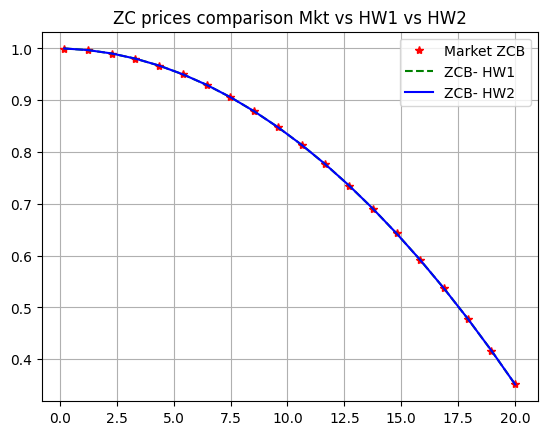

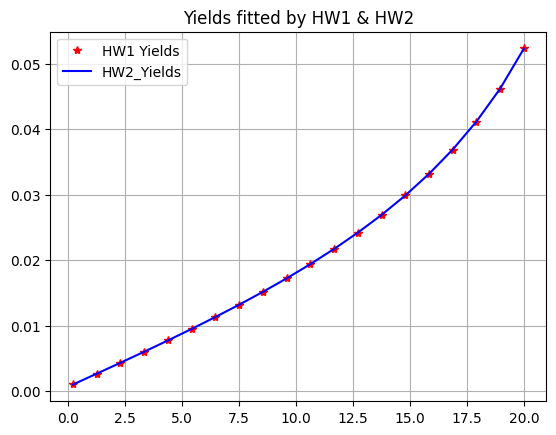

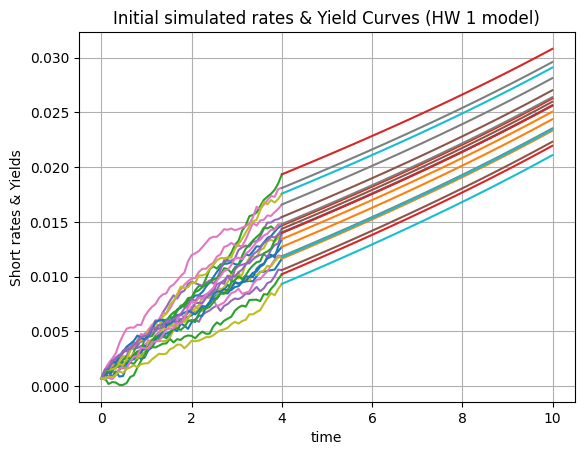

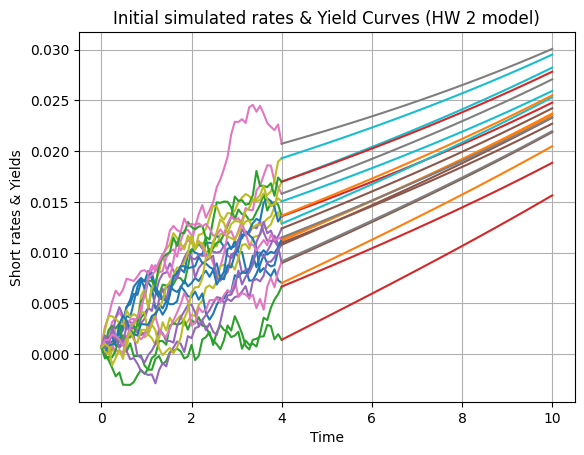

In [21]:
CompareHW1HW2()